In [81]:
import numpy as np
from patchify import patchify,unpatchify
import PIL
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import logging
import pickle as pk
import shutil

import rasterio
from pyproj import Transformer
from shapely.geometry import Polygon

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("rasterio").setLevel(logging.WARNING)
logging.getLogger("shapely").setLevel(logging.WARNING)

PIL.Image.MAX_IMAGE_PIXELS = 933120000

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
from skimage.measure import block_reduce

import cv2 as cv

In [2]:
class MapPatch():
    def __init__(self, patch, patch_index, origin_map):
        self.patch = patch
        self.patch_index = patch_index
        self.origin_map = origin_map
        
    @staticmethod
    def get_map_patches(file_name, patch_width, map_transformer = None, verbose = True):
        tif_map = PIL.Image.open(file_name)
        tif_map_np = np.array(tif_map)
        
        if map_transformer is not None and verbose:
            logging.info(f"Applying transformation {map_transformer.__name__} to {file_name}")
            tif_map_np = map_transformer(tif_map_np)
        
        tif_map_patches = patchify(image = tif_map_np, 
                                   patch_size = (patch_width, patch_width, 3),
                                   step = patch_width)

        if verbose:
            logging.info(f"{np.prod(tif_map_patches.shape[:2]):,} patches from {file_name} generated with shape {tif_map_patches.shape}")

        return tif_map_np, tif_map_patches
    
    @staticmethod
    def get_map_patch_list(file_name, patch_width, map_transformer = None, verbose = True):
        _, tif_map_patches = MapPatch.get_map_patches(file_name, 
                                                      patch_width, 
                                                      map_transformer = map_transformer, 
                                                      verbose = verbose)
        patches = []
        
        for i in range(tif_map_patches.shape[0]):
            for j in range(tif_map_patches.shape[1]):
                patches.append(MapPatch(tif_map_patches[i,j,0], patch_index = (i,j), origin_map = file_name))
                
        return patches
    
    def show(self, verbose = True):
        fig, ax = plt.subplots()
        ax.imshow(self.patch)
        
        if verbose:
            ax.set_title(f"Patch at {self.patch_index} from {self.origin_map}.")
            
        plt.show()

In [3]:
class PatchDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, i):
        if isinstance(i, slice):
            start = i.start if i.start else 0
            stop = i.stop if i.stop else len(self.patches)
            step = i.step if i.step else 1
            
            return [(self.patches[j], self.patches[j].origin_map) for j in range(start, stop, step)]
        
        return (self.patches[i], self.patches[i].origin_map)
    
    @classmethod
    def from_dir(cls, directory, file_ext, patch_width, map_transformer = None):
        patches = []
        
        if file_ext == "tif":
            for file in os.listdir(directory):
                if file.endswith("tif"):
                    file_name = f"{directory}/{file}"
                    logging.info(f"Fetching patches from {file_name}.")
                    patches.extend(MapPatch.get_map_patch_list(file_name = file_name, 
                                                               patch_width = patch_width, 
                                                               map_transformer = map_transformer,
                                                               verbose = True))
        elif file_ext == "pk":
            for file in os.listdir(directory):
                if file.endswith("pk"):
                    file_name = f"{directory}/{file}"
                    logging.info(f"Fetching patches from {file_name}.")
                    with open(file_name, "rb") as f:
                        patches.extend(pk.load(file_name))
        else:
            print(f"{file_ext} is an invalid file format. Require tif or pk.")
            
        return cls(patches)
    
    def to_pickle(self, file_name = None):
        with open(f"{file_name}.pk", "wb") as f:
            pk.dump(self.patches, f)

In [4]:
# transformations to apply to the map

def max_pooler(img, kernel_size):
    return block_reduce(img, block_size = (kernel_size, kernel_size,1), func = np.max)

def min_pooler(img, kernel_size):
    return block_reduce(img, block_size = (kernel_size, kernel_size,1), func = np.min)

def med_reduce(x, axis):
    return np.median(x,axis).astype(np.int32)

def med_pooler(img, kernel_size):
    return block_reduce(img, block_size = (kernel_size, kernel_size,1), func = med_reduce)

def mean_reduce(x, axis):
    return np.mean(x,axis).astype(np.int32)

def mean_pooler(img, kernel_size):
    return block_reduce(img, block_size = (kernel_size, kernel_size,1), func = mean_reduce)

def torch_downsample(img, kernel_size, interpolation = InterpolationMode.BILINEAR):
    size = img.shape
    
    new_size = (size[0]//kernel_size, size[1]//kernel_size)
    
    tensor_img = np.moveaxis(img, -1, 0)
    tensor_img = torch.Tensor(tensor_img)
    
    resized_map = T.Resize(new_size, interpolation=interpolation)(tensor_img)
    
    resized_map = resized_map.numpy()
    resized_map = np.moveaxis(resized_map, 0, -1)
    
    return resized_map.astype(int)

def bilinear_interpolator(img, kernel_size):
    return torch_downsample(img, kernel_size, interpolation = InterpolationMode.BILINEAR)

def bicubic_interpolator(img, kernel_size):
    return torch_downsample(img, kernel_size, interpolation = InterpolationMode.BICUBIC)

In [5]:
def bilinear_interpolator_4x4(img):
    return bilinear_interpolator(img, 4)

patch_data = PatchDataset.from_dir("../data", 
                           file_ext = "tif", 
                           patch_width = 64, 
                           map_transformer= bilinear_interpolator_4x4)                    

INFO:root:Fetching patches from ../data/map_3.tif.
INFO:root:Applying transformation bilinear_interpolator_4x4 to ../data/map_3.tif
INFO:root:2,301 patches from ../data/map_3.tif generated with shape (39, 59, 1, 64, 64, 3)
INFO:root:Fetching patches from ../data/map_2.tif.
INFO:root:Applying transformation bilinear_interpolator_4x4 to ../data/map_2.tif
INFO:root:2,301 patches from ../data/map_2.tif generated with shape (39, 59, 1, 64, 64, 3)
INFO:root:Fetching patches from ../data/map_1.tif.
INFO:root:Applying transformation bilinear_interpolator_4x4 to ../data/map_1.tif
INFO:root:2,301 patches from ../data/map_1.tif generated with shape (39, 59, 1, 64, 64, 3)
INFO:root:Fetching patches from ../data/map_4.tif.
INFO:root:Applying transformation bilinear_interpolator_4x4 to ../data/map_4.tif
INFO:root:2,301 patches from ../data/map_4.tif generated with shape (39, 59, 1, 64, 64, 3)


In [25]:
class PatchAligner():
    def __init__():
        return None
    
    @staticmethod
    def plot_colour_hist(patch, grayscale = True):
        
        hist_patch = patch
        
        if grayscale:
            gray_hist = cv.calcHist([cv.cvtColor(patch, cv.COLOR_BGR2GRAY)], [0], None, [256], [0,256])
        
            fig, ax = plt.subplots()
            ax.plot(gray_hist)
            plt.show()
            
        else:
            blue_hist = cv.calcHist([patch], [0], None, [256], [0, 256])
            red_hist = cv.calcHist([patch], [1], None, [256], [0, 256])
            green_hist = cv.calcHist([patch], [2], None, [256], [0, 256])
            
            fig, ax = plt.subplots()
            ax.plot(blue_hist, c = "blue")
            ax.plot(red_hist, c = "red")
            ax.plot(green_hist, c = "green")
            plt.show()
      
    @staticmethod
    def show(patch, cmap = "gray"):
        fig, ax = plt.subplots()
        ax.imshow(patch, cmap = cmap)
        plt.show()
            
    @staticmethod
    def pad_thresh_patch(patch, padding_size, threshold_type = None, threshold = None):
        """
        For gaussian thresholding, use threshold_type = cv.ADAPTIVE_THRESH_GAUSSIAN_C.
        For mean threshold, use threshold_type = cv.ADAPTIVE_THRESH_MEAN_C
        """
        gray_patch = cv.cvtColor(patch, cv.COLOR_BGR2GRAY)
        
        if threshold_type is None:
            assert threshold is not None, "If threshold_type is None, you need to provide a threshold value."
            
            _, thresh_gray_patch = cv.threshold(gray_patch, threshold, 255, cv.THRESH_BINARY)
        else:
            thresh_gray_patch = cv.adaptiveThreshold(gray_patch, 255, threshold_type, cv.THRESH_BINARY, 11, 2)
            
        return cv.copyMakeBorder(thresh_gray_patch, padding_size, padding_size, padding_size, padding_size, 
                                       cv.BORDER_CONSTANT, value=(255,255,255))
    @staticmethod
    def shift_patch(patch, x_shift, y_shift):
        M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
        
        #x>0 shift right，x<0 shift left
        #y>0 shift down，y<0 move up
        
        return cv.warpAffine(patch, M, (patch.shape[1], patch.shape[0]), borderValue=(255,255,255))
    
    @staticmethod
    def get_best_shift_value(align_patch, reference_patch, padding_size):
        shift_list = [(i,j) for i in range(-padding_size,padding_size+1) for j in range(-padding_size,padding_size+1)]
        
        xor_sum = np.logical_xor(align_patch, reference_patch).sum()
        
        best_shift = (0,0)
        best_xor = xor_sum
        for shift_value in shift_list:
            # shift the image
            res = PatchAligner.shift_patch(align_patch, shift_value[0], shift_value[1])
            xor = np.logical_xor(res, reference_patch).sum()
            
            if xor < best_xor:
                best_shift = shift_value
                best_xor = xor
                
        return best_shift
    
    @staticmethod
    def get_patch_alignment(align_patch, reference_patch, padding_size):
        align_patch_ = PatchAligner.pad_thresh_patch(align_patch, padding_size, 
                                                     threshold_type = cv.ADAPTIVE_THRESH_MEAN_C)
        reference_patch_ = PatchAligner.pad_thresh_patch(reference_patch, padding_size, 
                                                         threshold_type = cv.ADAPTIVE_THRESH_MEAN_C)

        return PatchAligner.get_best_shift_value(align_patch_, reference_patch_, padding_size)
    
    @staticmethod
    def plot_best_alignment_heatmap(align_patches, reference_patches, padding_size, cmap = "gray"):
        alignment_count = np.zeros((2*padding_size+1, 2*padding_size+1))
        
        for i in range(len(align_patches)):
            x_shift, y_shift = PatchAligner.get_patch_alignment(align_patches[i], reference_patches[i], padding_size)
            alignment_count[x_shift + padding_size, y_shift + padding_size] += 1
            
        PatchAligner.show(alignment_count, cmap)
        
        return alignment_count
        
    
    @staticmethod
    def overlap_patches(patch_1, patch_2):
        overlap = patch_1.copy()
        overlap[:, :, 1] = 0
        overlap[:, :, 2] = patch_2[:, :, 2]

        b = patch_1.copy()
        # set green and red channels to 0
        b[:, :, 1] = 0
        b[:, :, 2] = 0

        r = patch_2.copy()
        # set blue and green channels to 0
        r[:, :, 0] = 0
        r[:, :, 1] = 0
        
        fig = plt.figure(constrained_layout=False)

        gs = GridSpec(2, 3, figure=fig)
        ax_overlap = fig.add_subplot(gs[0:2,0:2])
        ax_b = fig.add_subplot(gs[0,2])
        ax_r = fig.add_subplot(gs[1,2])
        
        ax_overlap.imshow(overlap)
        ax_overlap.set_title("Overlap")
        ax_b.imshow(b)
        ax_b.set_title("First Patch")
        ax_r.imshow(r)
        ax_r.set_title("Second Patch")
        
        plt.show()

(0, 0)


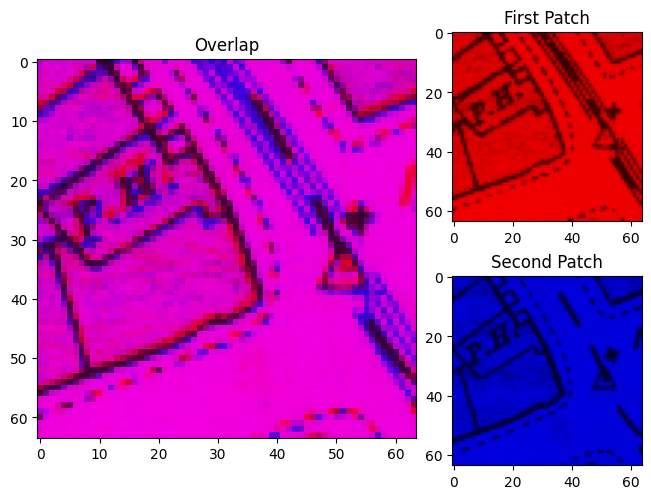

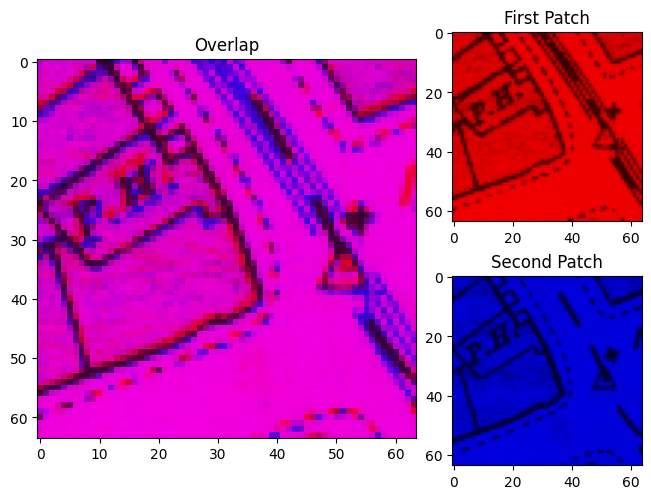

In [26]:
img1 = np.uint8(patch_data[0][0].patch)
img2 = np.uint8(patch_data[2301][0].patch)

best_shift = PatchAligner.get_patch_alignment(img1, img2, 6)
print(best_shift)
PatchAligner.overlap_patches(img1, img2)
shift_img1 = PatchAligner.shift_patch(img1, *best_shift)
PatchAligner.overlap_patches(shift_img1, img2)

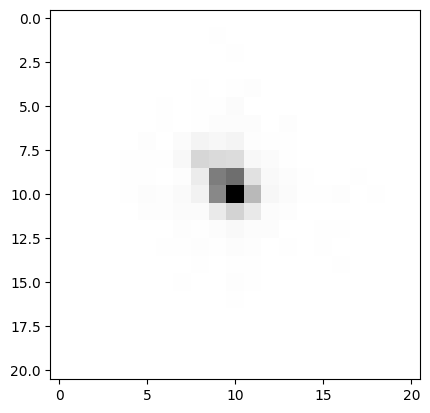

In [28]:
align_patches = [np.uint8(patch.patch) for patch in patch_data.patches[:2301]]
ref_patches = [np.uint8(patch.patch) for patch in patch_data.patches[2301:2*2301]]

alignment_count = PatchAligner.plot_best_alignment_heatmap(align_patches, ref_patches, 10, cmap = "gray_r")

In [100]:
class MapAligner():
    def __init__(self, map_dir):
        self.map_dir = map_dir
        self.LONG_LAT_FORMAT = "EPSG:4326"
        
    def transfer_maps_to_dir(self, map_names, new_dir = None):
        """
        Moves a list of map files to a new directory. 
        Meant to provide a directory structure, where maps of the same region 
        get sent to the same directory.
        ----------------------------------------------------------------------------------------------
        :param map_names: a list of strings, giving the map file names 
                          (these should be stored in self.map_dir)
        :param new_dir: the subdirectory of self.map_dir where we want to store the maps in map_names.
                        If None, creates directories which are ordered numerically (1,2,...)
        """
        if new_dir is None:
            # get all subdirectories of self.map_dir which have a numerical name
            num_dirs = [int(directory[0][len(self.map_dir)+1:]) 
                        for directory in os.walk(self.map_dir) 
                        if directory[0][len(self.map_dir)+1:].isdigit()]

            if len(num_dirs) == 0:
                new_dir = "1"
            else:
                new_dir = f"{max(num_dirs) + 1}"
        
        # create new directory to store map_names
        new_map_dir = os.path.join(self.map_dir, new_dir)
        os.makedirs(new_map_dir)
        
        # transfer the maps from self.map_dir to the new map directory
        for map_name in map_names:
            map_path = os.path.join(self.map_dir, map_name)
            shutil.move(map_path, new_map_dir)
            
    def get_map_bbox(self, map_path, to_long_lat = False):
        """
        Given a path to a GeoTif, computes the bounding box for the GeoTif.
        The bounding box can either be based on the GeoTif's CRS, or using 
        longitude & latitude (CRS: EPSG:4326).
        -------------------------------------------------------------------
        :param map_path: file path to the GeoTif.
        :param to_long_lat: a boolean. If true, computes the bounding box 
                            using longitude and latitude.
        -------------------------------------------------------------------
        :return a tuple with 6 components:
                - the name of the GeoTif file
                - the bottom left coordinate of the bounding box
                - the bottom right coordinate of the bounding box
                - the top right coordinate of the bounding box
                - the top left coordinate of the bounding box
                - a boolean, whether the bounding box is defined by 
                  longitude and latitude
        """
        img_map = rasterio.open(map_path)

        map_bbox = img_map.bounds

        top_left = (map_bbox.left, map_bbox.top)
        top_right = (map_bbox.right, map_bbox.top)
        bottom_right = (map_bbox.right, map_bbox.bottom)
        bottom_left = (map_bbox.left, map_bbox.bottom)

        #map_name = map_path[map_path.rfind("/")+1 : -4]
        map_name = map_path[map_path.rfind("/")+1:]

        if to_long_lat:
            transformer = Transformer.from_crs(img_map.crs, self.LONG_LAT_FORMAT)

            conv_coords = lambda x: tuple(list(transformer.transform(*x))[::-1])

            return (map_name, 
                    conv_coords(bottom_left), 
                    conv_coords(bottom_right), 
                    conv_coords(top_right), 
                    conv_coords(top_left),
                    to_long_lat)
        else:
            return (map_name,
                    bottom_left,
                    bottom_right,
                    top_right,
                    top_left,
                    to_long_lat)
    @staticmethod 
    def bbox_area_prop(bbox_1, bbox_2):
        """
        Given 2 bounding boxes (represented as a 4-tuple), 
        computes the intersection of the 2, and determines the proportion 
        of area of the intersection with respect to each of the bounding boxes.
        ------------------------------------------------------------------------
        :param bbox_1: a 4-tuple of floats, representing a bounding box.
        :param bbox_2: a 4-tuple of floats, representing a bounding box.
        ------------------------------------------------------------------------
        :return a 2-tuple, containing the proportion of area of the intersection 
                of the 2 bounding boxes, with respect to each bounding box.
        """
        
        # create polygons using the bounding boxes
        p1 = Polygon(list(bbox_1))
        p2 = Polygon(list(bbox_2))
        
        # determine the intersection between bounding boxes
        p_intersect = p1.intersection(p2)

        # compute areas of bounding boxes and intersections
        area_bbox_1 = p1.area
        area_bbox_2 = p2.area
        area_bbox_intersect = p_intersect.area

        # return area proportions
        return (area_bbox_intersect/area_bbox_1, area_bbox_intersect/area_bbox_2)

    def group_maps_in_dir(self, thresh = 0.7, to_long_lat = False):
        """
        Given a directory containing GeoTifs, computes groups the GeoTifs.
        2 GeoTifs will be grouped together if their area of intersection
        (as defined by their bounding boxes) is above some user-defined threshold.
        --------------------------------------------------------------------------
        :param thresh: a float between 0 and 1. Gives the area proportion 
                       threshold required for 2 GeoTifs to be grouped together.
        :param to_long_lat: a boolean. If True, the bounding boxes are defined 
                            in terms of longitude and latitude.
        --------------------------------------------------------------------------
        :return a dictionary. 
                The keys will be a particular GeoTif, 
                whose corresponding values will be a list of GeoTifs.
                These GeoTifs are the ones whose intersection area proportion is 
                greater than thresh. Note, each GeoTif appears only once 
                (i.e if a Geotif x is grouped with Geotif y, 
                     y appears as a key, and x only appears in the list associated 
                     with y)
        """
        
        # compute all th ebounding boxes for the GeoTifs in map_dir
        bboxes = [self.get_map_bbox(os.path.join(self.map_dir, map_name), to_long_lat) 
                  for map_name in os.listdir(self.map_dir) 
                  if map_name.endswith("tif")]
        
        map_groups = {}

        # iterate over all the bounding boxes to find groupings
        for bbox in bboxes:
            map_groups[bbox[0]] = []
            for bbox_ in bboxes:

                # check if the bbox_ has already been seen
                if bbox_[0] in map_groups:
                    # if bbox is already grouped with bbox_, then it can't be a key
                    if bbox[0] in map_groups[bbox_[0]]:
                        map_groups.pop(bbox[0], None)
                        break

                # only compare distinct bounding boxes
                if bbox_[0] != bbox[0]:
                    
                    # compute intersection area proportion
                    area_prop = MapAligner.bbox_area_prop(tuple(list(bbox[1:-1])), 
                                                          tuple(list(bbox_[1:-1])))
                    # if intersection area proportion is above the threshold, group the GeoTifs
                    if max(area_prop) >= thresh:
                        map_groups[bbox[0]].append(bbox_[0])

        return map_groups
    
    def align_maps(self, thresh = 0.7, to_long_lat = False):
        """
        Splits self.map_dir, by creating subdirectories based on which GeoTifs can be aligned 
        (based on bounding box intersection area proportion).
        --------------------------------------------------------------------------
        :param thresh: a float between 0 and 1. Gives the area proportion 
                       threshold required for 2 GeoTifs to be grouped together.
        :param to_long_lat: a boolean. If True, the bounding boxes are defined 
                            in terms of longitude and latitude.
        """
        map_groups = self.group_maps_in_dir(thresh = thresh, to_long_lat = to_long_lat)
        
        for map_name, map_group in map_groups.items():
            aligned_maps = map_group + [map_name]
            self.transfer_maps_to_dir(aligned_maps, new_dir = None)
        

In [102]:
ma = MapAligner("../data/originals")
ma.group_maps_in_dir(0.7, to_long_lat=False)

{}